In [1]:
from enum import Enum
import math
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [2]:
class GreekType(str, Enum):
    Delta = "Delta"
    Gamma = "Gamma"
    Vega = "Vega"
    Theta = "Theta"
    Rho = "Rho"

In [3]:
def binomialGreeks(S, r, vol, T, strike, greekType) -> float:
    ans =[]
    OptionKind =[EuropeanOption(T,strike,PayoffType.Call),EuropeanOption(T,strike,PayoffType.Put),
                 AmericanOption(T,strike,PayoffType.Call),AmericanOption(T,strike,PayoffType.Put)]
    Calib = [crrCalib, jrrnCalib,jreqCalib,tianCalib]
    dS = 0.001
    dsigma = 0.001
    dt = 0.004
    dr = 0.0001
    n = 300
    S1, S2 = S*(1+dS), S*(1-dS)
    
    if greekType == GreekType.Delta: #"Delta":
        den = 1.0/(2*dS*S)
        for i in range (0,4):
            for j in range (0,4):
                V1 = binomialPricer(S1, r, vol, OptionKind[i], n, Calib[j])
                V2 = binomialPricer(S2, r, vol, OptionKind[i], n, Calib[j])
                delta = (V1-V2)*den
                ans.append(delta)
    
    elif greekType ==GreekType.Gamma:
        den= 1.0/((dS*S)**2)
        for i in range (0,4):
            for j in range(0,4):
                Vs = binomialPricer(S, r, vol, OptionKind[i], n, Calib[j])
                V1 = binomialPricer(S1, r, vol, OptionKind[i], n, Calib[j])
                V2 = binomialPricer(S2, r, vol, OptionKind[i], n, Calib[j])
                gamma = (V1+V2-2*Vs)*den
                ans.append(gamma)
    
    elif greekType == GreekType.Vega:
        vol1 = vol + dsigma
        vol2 = vol - dsigma
        den = 1.0/(2*dsigma)
        for i in range (0,4):
            for j in range(0,4):
                V1 = binomialPricer(S, r, vol1, OptionKind[i], n, Calib[j])
                V2 = binomialPricer(S, r, vol2, OptionKind[i], n, Calib[j])
                vega = (V1-V2)*den
                ans.append(vega)
                
    elif greekType == GreekType.Theta:
        T1 = T - dt
        OptionKindtheta=[EuropeanOption(T1,strike,PayoffType.Call), EuropeanOption(T1,strike,PayoffType.Put),
        AmericanOption(T1,strike,PayoffType.Call),AmericanOption(T1,strike,PayoffType.Put)]
        for i in range(0,4):
            for j in range(0,4):
                V1 = binomialPricer(S, r, vol, OptionKindtheta[i], n, Calib[j])
                Vs = binomialPricer(S, r, vol, OptionKind[i], n, Calib[j])
                theta = (Vs-V1)/dt
                ans.append(theta)
                    
                    
    elif greekType == GreekType.Rho:
        r1 = r+dr
        r2 = r-dr
        for i in range(0,4):
            for j in range(0,4):
                V1 = binomialPricer(S, r1, vol, OptionKind[i], n, Calib[j])
                Vs = binomialPricer(S, r2, vol, OptionKind[i], n, Calib[j])
                rho = (V1-Vs)/(2*dr)
                ans.append(rho)
    return ans

In [4]:
S,r,vol,T,t = 100, 0.03, 0.2, 1,0
K = list(range (50,151))

greekTypes = [GreekType.Delta, GreekType.Gamma, GreekType.Vega, GreekType.Theta, GreekType.Rho]
results = {type_i:[] for type_i in greekTypes}

for strike in range (50,151):
    for type_i in greekTypes:
        result = binomialGreeks(S,r,vol,T,strike,type_i)
        results[type_i].append(result)

In [5]:
import pandas as pd

cols = ["European Call & crrCalib","European Call & jrrnCalib",
        "European Call & jreqCalib","European Call & tianCalib",
        "European Put & crrCalib","European Put & jrrnCalib",
        "European Put & jreqCalib","European Put & tianCalib",
        "American Call & crrCalib","American Call & jrrnCalib",
        "American Call & jreqCalib","American Call & tianCalib",
        "American Put & crrCalib","American Put & jrrnCalib",
        "American Put & jreqCalib","American Put & tianCalib"]

for type_i in greekTypes:
    data = results[type_i]
    df = pd.DataFrame(data,index=K, columns=cols)
    results[type_i] = df

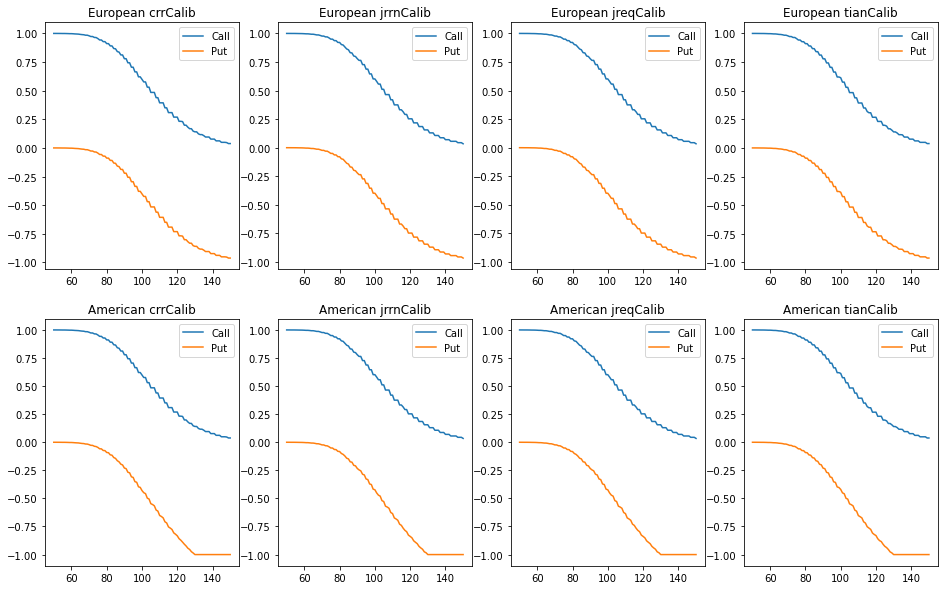

In [6]:
import matplotlib.pyplot as plt

# Delta
data = results[GreekType.Delta]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2):
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call")
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put")
        axs[i, j].legend()

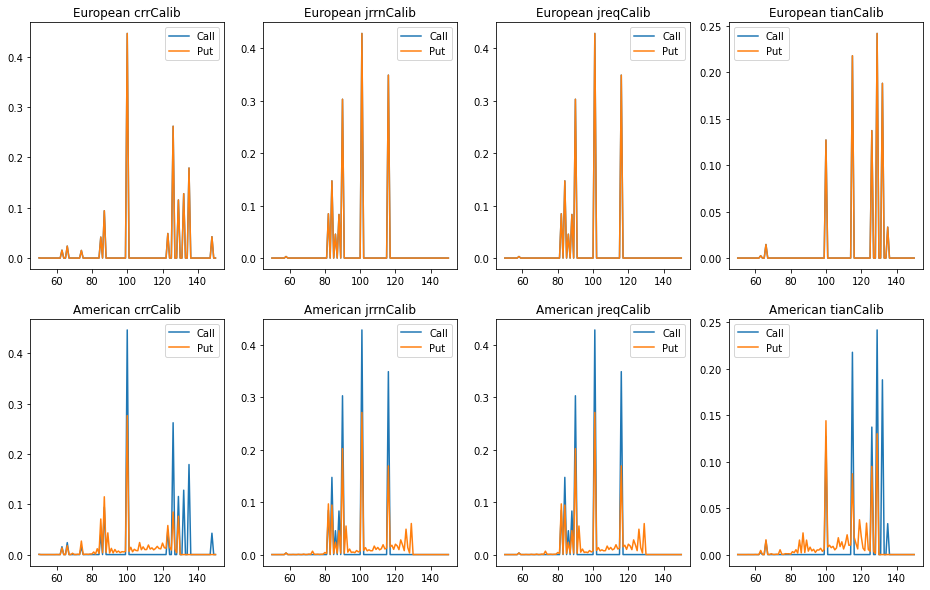

In [7]:
# Gamma
data = results[GreekType.Gamma]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2):
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call")
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put")
        axs[i, j].legend()

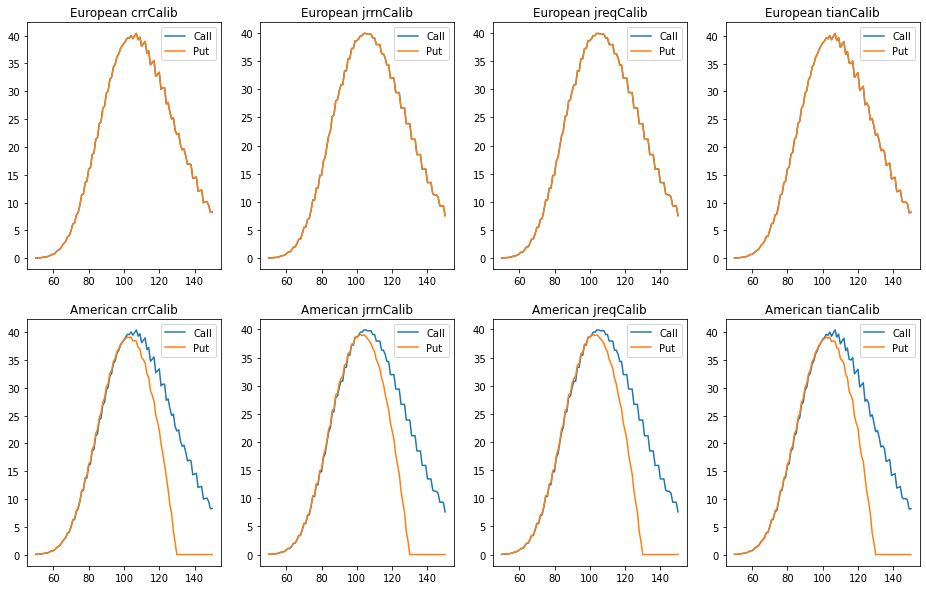

In [8]:
# Vega
data = results[GreekType.Vega]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2):
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call")
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put")
        axs[i, j].legend()

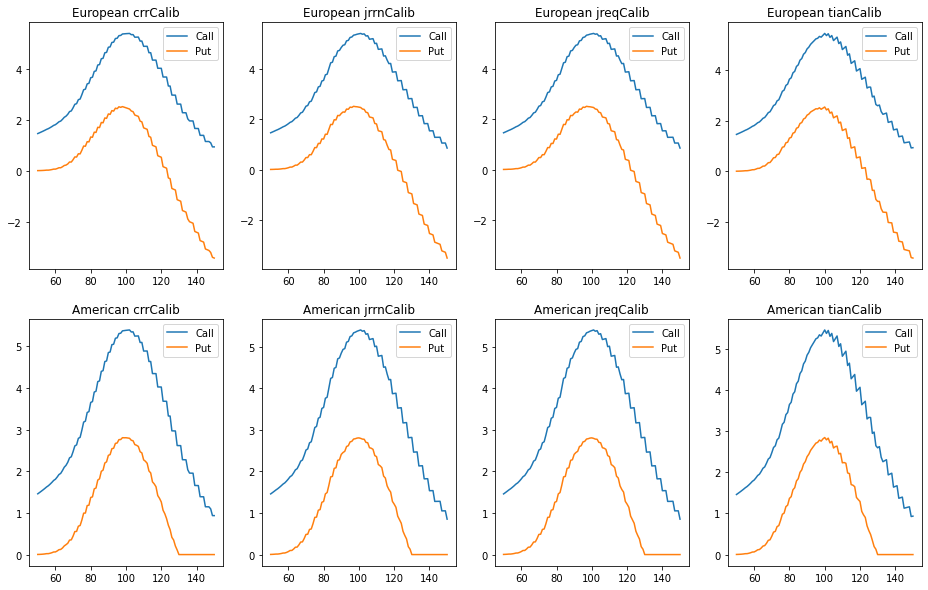

In [9]:
# theta
data = results[GreekType.Theta]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2):
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call")
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put")
        axs[i, j].legend()

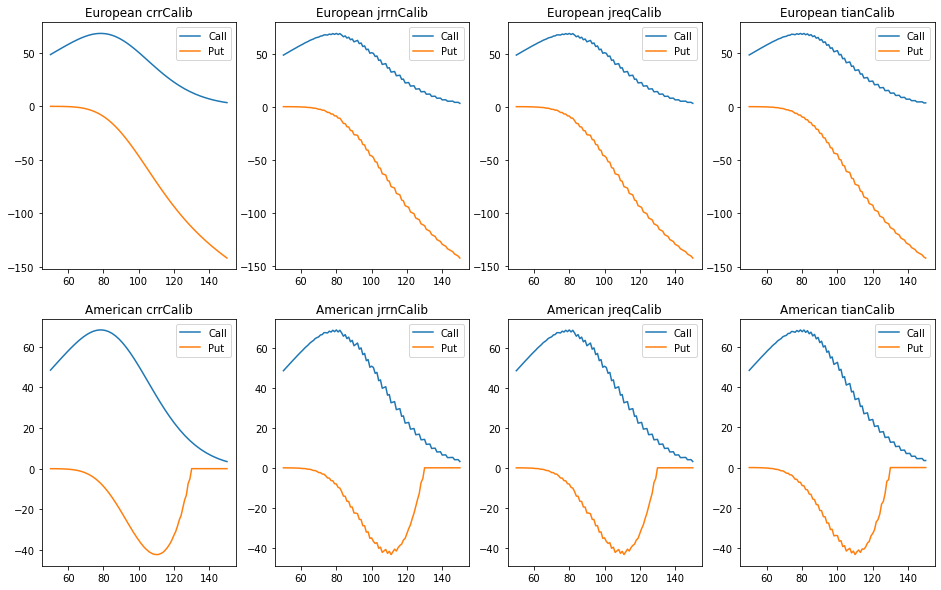

In [10]:
# Rho
data = results[GreekType.Rho]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2):
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call")
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put")
        axs[i, j].legend()